## <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h6>Sr. no.</h6></td> <td><h6>Section</h6></td> <td><h6>Points</h6></td> </tr>
        <tr><td><h6>1</h6></td> <td><h6>1.1. Dataset Class</h6></td> <td><h6>7</h6></td> </tr>
        <tr><td><h6>2</h6></td> <td><h6>1.2. Visualize dataset</h6></td> <td><h6>3</h6></td> </tr>
        <tr><td><h6>3</h6></td> <td><h6>2. Evaluation Metrics</h6></td> <td><h6>10</h6></td> </tr>
        <tr><td><h6>4</h6></td> <td><h6>3. Model</h6></td> <td><h6>10</h6></td> </tr>
        <tr><td><h6>5</h6></td> <td><h6>4.1. Train</h6></td> <td><h6>7</h6></td> </tr>
        <tr><td><h6>6</h6></td> <td><h6>4.2. Inference</h6></td> <td><h6>3</h6></td> </tr>
        <tr><td><h6>7</h6></td> <td><h6>5. Prepare Submission CSV</h6></td><td><h6>10</h6></td> </tr>
        <tr><td><h6>8</h6></td> <td><h6>6. Kaggle Profile Link</h6></td> <td><h6>50</h6></td> </tr>
    </table>
</div>

---

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions.

In [1]:
DATA_PATH = "/kaggle/input/opencv-pytorch-segmentation-project/"
OUTPUT_PATH = "/kaggle/working/"

In [2]:
!pip install --quiet albumentations
!pip install --quiet torch-lr-finder
!pip install --quiet segmentation-models-pytorch
!pip install --quiet pytorch_toolbelt
!pip install --quiet iterative-stratification
!pip install --quiet torcheval

In [3]:
# Standard Library imports
import time
from pathlib import Path
import os
from collections import defaultdict
import gc
import pickle
import copy

# External imports
import cv2
import torch
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from tqdm.autonotebook import tqdm
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torch_lr_finder import LRFinder
import segmentation_models_pytorch as smp
from pytorch_toolbelt.utils.rle import rle_encode, rle_to_string
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torcheval.metrics import MulticlassConfusionMatrix

plt.style.use('bmh')

/tmp/ipykernel_23/679689891.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
def plot(x, ys:list, labels:list, title:str):
    """
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10, 3))
    for i,y in enumerate(ys):
        label = labels[i]
        plt.plot(x, y, label=label, marker='o')
    
    plt.legend()
    ax.set_xlabel("Epoch")
    ax.grid(which='major', color='black', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-', alpha=0.2)
    plt.title(title)
    
    return fig, ax

In [5]:
def plot_loss_and_score(epochs, H):
    """
    """
    
    x = [i for i in range(1, epochs+1)]
    
    # Loss graph
    y = [H["train_loss"], H["valid_loss"]]
    labels = ["Train loss", "Validation loss"]
    fig0,ax0 = plot(x, y, labels, "Loss")
    plt.show()

    # Score graph
    y = [H["train_score"], H["valid_score"]]
    labels = ["Train mean Dice", "Validation mean Dice"]
    fig1,ax1 = plot(x, y, labels, "Mean Dice score")
    ax1.yaxis.set_major_locator(MultipleLocator(0.05))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.01))
    plt.show()

In [6]:
def plot_score_per_class(H):
    """
    """
    
    epochs = len(H["per_class_score"])
    
    x = [i for i in range(1, epochs+1)]
    ys = list(zip(*H["per_class_score"]))

    fig, axes = plt.subplots(nrows=config.NUM_CLASSES, ncols=1, sharey=True, sharex=True, figsize=(8, 24))

    for i in range(len(ys)):
        y = ys[i]
        axes[i].plot(x, y, label = f"Class {i}", marker='o')
        axes[i].legend(loc=2)
        axes[i].set_ylim([0, 1])
        axes[i].xaxis.set_tick_params(which='major', length=0)
        axes[i].xaxis.set_major_locator(MultipleLocator(1))
        axes[i].yaxis.set_major_locator(MultipleLocator(1))
        axes[i].yaxis.set_major_locator(MultipleLocator(0.5))
        axes[i].yaxis.set_minor_locator(MultipleLocator(0.1))
        axes[i].grid(which='major', color='black', linestyle='-')
        axes[i].grid(which='minor', color='gray', linestyle='-', alpha=0.2)

    fig.supxlabel('Epoch')
    fig.supylabel('Dice coefficient')

    plt.tight_layout()
    plt.show()

In [7]:
class ClearCache:
    def __enter__(self):
        torch.cuda.empty_cache()
        gc.collect()

    def __exit__(self, exc_type, exc_val, exc_tb):
        torch.cuda.empty_cache()
        gc.collect()

<h2>Configuration</h2>

In [8]:
class Config:
    LOAD_MODEL = True
    TRAINED_MODEL_PATH = "/kaggle/input/model-epoch-13/deeplabv3_model_epoch_13.pkl"
    
    BATCH_SIZE = 2 if torch.cuda.is_available() else 2
    GRADIENT_ACCUMULATION_STEPS = 8
    EPOCHS = 10
    NUM_CLASSES = 12
    
    LR = 9e-4  # Used when the scheduler returns a constant value (LinearLR)
    MAX_LR = 5e-3  # Used when the scheduler is OneCycleLR
    MIN_LR = 1e-5  # Used with CosineAnnealing
    MOMENTUM = 0.937 # SGD momentum/Adam beta1, from Yolo v5
    WEIGHT_DECAY = 0.001 # optimizer weight decay
    
    NUM_WORKERS = 4  # There are 4 CPUs in Kaggle
    TRAIN_SPLIT = 0.8

    # This is basically the "background" class
    MASK_FILL_VALUE = 0

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = Config()

# <font style="color:green">1. Data Exploration</font>

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

In [9]:
class SemSegDataset(Dataset):
    """
    Generic Dataset class for semantic segmentation datasets.
    """

    def __init__(
        self,
        data_path,
        images_folder,
        masks_folder,
        image_ids,
        train_val_test,
        transforms=None,
    ):
        """
        Args:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images.
            masks_folder (string): Name of the folder containing the masks.
            image_ids (list): List of image IDs to include in the dataset.
            train_val_test (string): 'train', 'val', or 'test'.
            transforms (callable, optional): A function/transform that takes in a sample and returns a transformed version.
        """

        self.data_path = data_path
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.image_ids = image_ids
        self.train_val_test = train_val_test
        self.transforms = transforms


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # Get image and mask paths
        image_path = os.path.join(self.data_path, self.images_folder, f"{image_id}.jpg")
        mask_path = os.path.join(self.data_path, self.masks_folder, f"{image_id}.png")

        # Load image and mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms is not None:
            if mask is None:
                return self.transforms(image=image)['image']
            else:
                transformed = self.transforms(image=image, mask=mask)

            return transformed['image'], transformed['mask']
        
        return image, mask

In [10]:
train_csv_path = Path(DATA_PATH) / "train.csv"
test_csv_path = Path(DATA_PATH) / "test.csv"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

test_ids = test_df.ImageID.ravel().tolist()

/tmp/ipykernel_23/58666133.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  test_ids = test_df.ImageID.ravel().tolist()


In [11]:
whole_dataset = SemSegDataset(
    DATA_PATH,
    "imgs/imgs",
    "masks/masks",
    train_df.ImageID,
    train_val_test="train"
)

def extract_and_onehot_encode_classes_from_multilabel_masks(dataset):
    """
    Extract the classes available in each multilabel binary mask and one-hot encodes them.

    Returns:
        A NumPy array of one-hot encoded classes, where the dimensions are
        (num_images, num_classes). Each value in the array represents the presence
        (1) or absence (0) of a specific class in the corresponding image.
    """
    ys = []
    for i in tqdm(range(len(dataset))):
        image, mask = dataset[i]
        y = np.unique(mask).reshape(1,-1)
        y = torch.Tensor(y).to(torch.int64)
        y = torch.nn.functional.one_hot(y, num_classes=config.NUM_CLASSES)
        y = y.sum(axis=1)
        y = y.numpy()
        ys.append(y)
    
    return np.concatenate(ys, axis=0)

In [12]:
X = train_df.ImageID
y = extract_and_onehot_encode_classes_from_multilabel_masks(whole_dataset)

  0%|          | 0/2621 [00:00<?, ?it/s]

In [13]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=(1-config.TRAIN_SPLIT), random_state=0)

for train_index, val_index in msss.split(X, y):
    train_ids, valid_ids = X[train_index], X[val_index]

In [14]:
TRANSFORMS_PROBABILITY = 0.75

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(
        limit=10,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.1, 
    ),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        rotate_limit=0,  # degrees
        scale_limit=0.2,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=config.MASK_FILL_VALUE,
        interpolation=cv2.INTER_CUBIC,
        p=0.1,
    ),
    A.ElasticTransform(
        alpha=60,
        sigma=8,
        value=0,
        mask_value=config.MASK_FILL_VALUE,
        border_mode=cv2.BORDER_CONSTANT,
        interpolation=cv2.INTER_CUBIC,
        p=TRANSFORMS_PROBABILITY,
    ),
    A.GridDistortion(
        num_steps=10,
        distort_limit=0.35,
        value=0,
        mask_value=config.MASK_FILL_VALUE,
        border_mode=cv2.BORDER_CONSTANT,
        interpolation=cv2.INTER_CUBIC,
        p=TRANSFORMS_PROBABILITY,
    ),
    A.OpticalDistortion(
        distort_limit=0.05,
        shift_limit=0.05,
        p=TRANSFORMS_PROBABILITY
    ),
    
    A.ColorJitter(
        brightness=(0.5, 1.5),
        contrast=(0.5, 1.5),
        saturation=(0.5, 1.5),
        hue=0.01,  # must be in this interval [-0.5, 0.5].
        p=TRANSFORMS_PROBABILITY
    ),
    A.Blur(p=0.01),
    A.MedianBlur(p=0.01),
    A.ToGray(p=0.01),
    A.CLAHE(p=0.01),
    A.RandomGamma(p=0.01),
    A.ImageCompression(
        quality_lower=75,
        p=0.01
    ),
    
    A.Normalize(),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Normalize(),
    ToTensorV2()
])


train_dataset = SemSegDataset(
    DATA_PATH,
    "imgs/imgs",
    "masks/masks",
    train_ids.tolist(),
    train_val_test="train",
    transforms=train_transforms,
)

valid_dataset = SemSegDataset(
    DATA_PATH,
    "imgs/imgs",
    "masks/masks",
    valid_ids.tolist(),
    train_val_test="validation",
    transforms=valid_transforms
)

# Reason for drop_last: https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274/5
train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True, num_workers=config.NUM_WORKERS)
valid_dataloader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=False, drop_last=True, num_workers=config.NUM_WORKERS)

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

In [15]:
def denormalize(tensors):
    """
    Denormalize image tensors back to range [0.0, 1.0]
    
    Modified from: Deep Learning with PyTorch - OpenCV University
    """

    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    
    tensors = tensors.clone()
    for c in range(3):
        if len(tensors.shape) == 4:
            tensors[:, c, :, :].mul_(std[c]).add_(mean[c])
        elif len(tensors.shape) == 3:
            tensors[c, :, :].mul_(std[c]).add_(mean[c])
        else:
            raise Exception("Can only deal with images of shape (N, C, H, W) or (C, H, W)")

    return torch.clamp(tensors.cpu(), 0.0, 1.0)

In [16]:
def draw_color_masked_image(image, mask, ax, is_cv_im=False):
    """
    """
    # Create colors for the visualization, one for each class
    MASK_CLASS_COLORS = np.array([
        [0, 0, 0], # background
        [192, 128, 128], # person
        [0, 128, 1], # bike
        [128, 128, 128], # car
        [128, 0, 0], # drone
        [1, 0, 128], # boat
        [193, 0, 129], # animal
        [192, 0, 0], # obstacle
        [192, 129, 0], # construction
        [0, 65, 1], # vegetation
        [127, 128, 0], # road
        [0, 128, 129], # sky
    ])
        
    if not is_cv_im:
        image = denormalize(image)
        image = image.permute(1, 2, 0).detach().cpu().numpy()  # CHW -> HWC
        mask = mask.detach().cpu().numpy().astype(np.uint8)
    
    mask = MASK_CLASS_COLORS[mask]
        
    ax[0].imshow(image)
    ax[0].set_xlabel("Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    ax[1].imshow(mask)
    ax[1].set_xlabel("Ground truth mask")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

In [17]:
def draw_semantic_segmentation_batch(dataset, n_samples=3):
    """
    """
    fig, axes = plt.subplots(nrows=n_samples, ncols=2, sharey=True, figsize=(10, 3*n_samples))
    for i in range(n_samples):
        image, mask = dataset[i]
        ax = axes[i]
        draw_color_masked_image(image, mask, ax)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

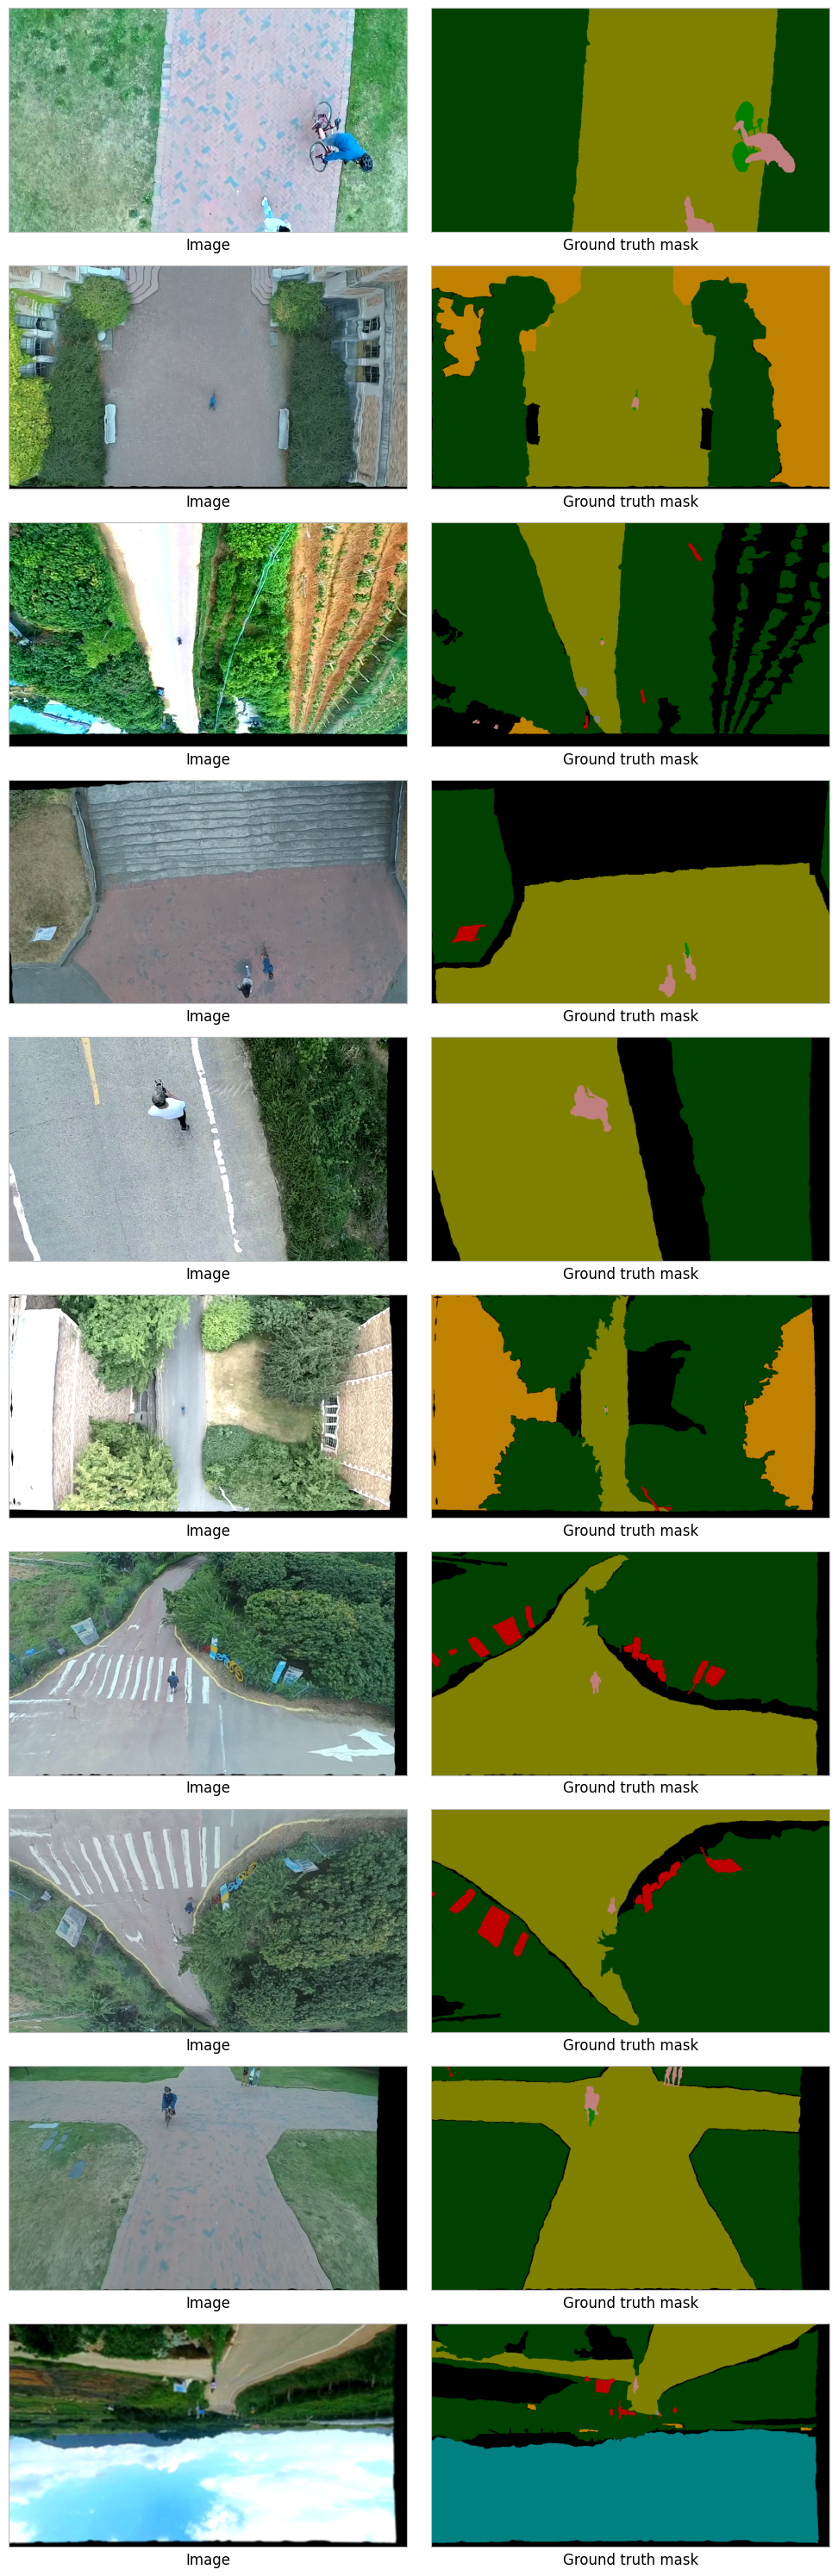

In [18]:
draw_semantic_segmentation_batch(train_dataset, n_samples=10)

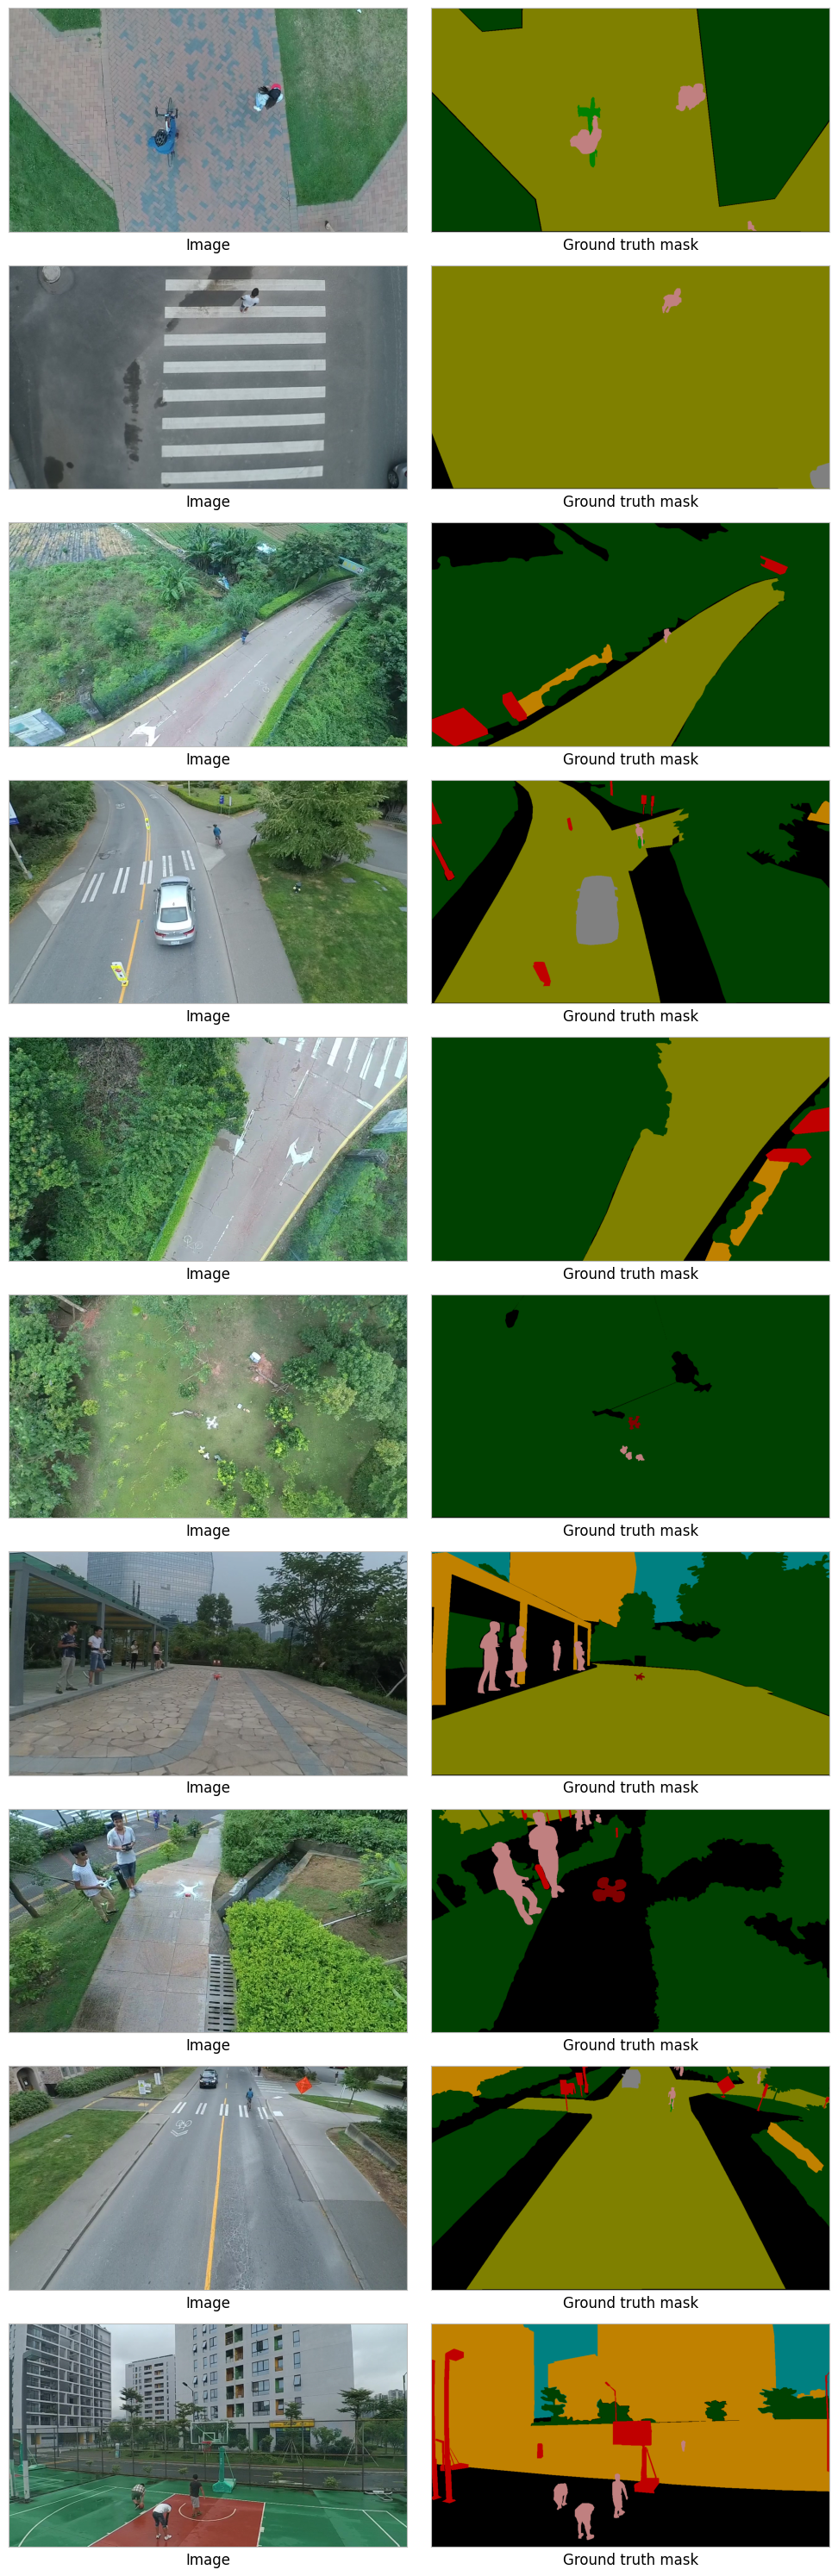

In [19]:
draw_semantic_segmentation_batch(valid_dataset, n_samples=10)

In [20]:
LABELS_NAMES_MAP = {
    0: "background",
    1: "person",
    2: "bike",
    3: "car",
    4: "drone",
    5: "boat",
    6: "animal",
    7: "obstacle",
    8: "construction",
    9: "vegetation",
    10: "road",
    11: "sky"
}

## Visualize each class

In [21]:
def draw_mask_overlay(image, mask, class_id, alpha=0.5, color=(0, 0, 1)):
    """ """
    
    image = denormalize(image)
    image = image.permute(1, 2, 0).detach().cpu().numpy()  # CHW -> HWC
    mask = mask.detach().cpu().numpy().astype(np.uint8)
    
    overlay = np.copy(image)
    overlay[mask==class_id] = color
    cv2.addWeighted(overlay, alpha, image, 1-alpha, 0, dst=overlay)

    return overlay

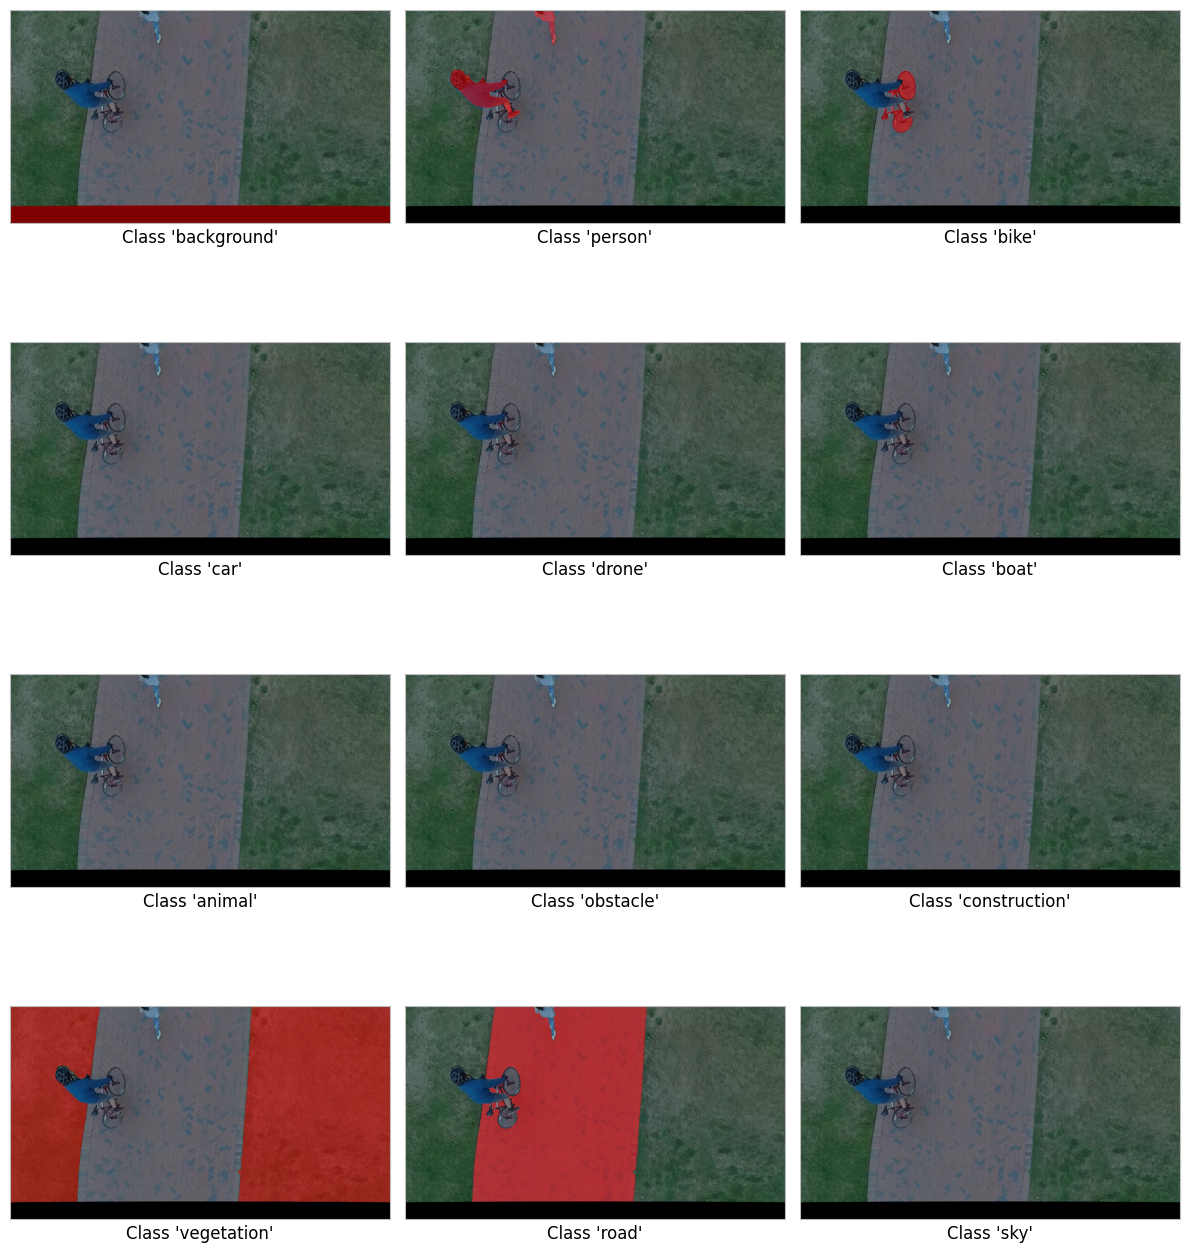

In [22]:
image, mask = train_dataset[0]
fig, axes = plt.subplots(nrows=np.ceil(config.NUM_CLASSES//3).astype(np.uint8), ncols=3, sharey=True, figsize=(12, 14))
for i in range(config.NUM_CLASSES):  
    overlay = draw_mask_overlay(image, mask, i, alpha=0.5, color=(1,0,0))

    ax = axes.flatten()[i]
    ax.imshow(overlay)
    ax.set_xlabel(f"Class '{LABELS_NAMES_MAP[i]}'")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
plt.close(fig)    

In [23]:
def count_images_per_class(dataset):
    """
    """
    
    d = defaultdict(int)
    for i in tqdm(range(len(dataset))):
        image, mask = dataset[i]
        classes = np.unique(mask)
        for c in classes:
            d[c] += 1
    
    return d

In [24]:
# dataset_count = count_images_per_class(whole_dataset)

In [25]:
# NOTE: if the train dataset pipeline does random cropping during augmentation,
# there may be less classes in an augmented train image than in the original image
# train_count = count_images_per_class(train_dataset)

In [26]:
# valid_count = count_images_per_class(valid_dataset)

In [27]:
# for i in range(config.NUM_CLASSES):
#     print(f"Class {i:02}: total: {dataset_count[i]:04} | train: {train_count[i]:04} | valid: {valid_count[i]:04}")

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

In [28]:
class DiceScore(torch.nn.Module):
    """
    """

    def __init__(self, num_classes, ignore_index=0):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index: int = ignore_index
        self.eps = 1e-6
        self.metric = MulticlassConfusionMatrix(self.num_classes)

    def __call__(self, pred, target):
        """
        pred: NxHxW
        target: NxCxHxW
        """
        self.metric.reset()
        
        self.metric.update(pred.flatten(), target.flatten())
        conf_matrix =  self.metric.compute()

        true_positive = torch.diag(conf_matrix)
        false_positive = torch.sum(conf_matrix, 0) - true_positive
        false_negative = torch.sum(conf_matrix, 1) - true_positive

        DSC = (2 * true_positive + self.eps) / (
            2 * true_positive + false_positive + false_negative + self.eps
        )
        
        return DSC

# <font style="color:green">3. Model [10 Points]</font>

In [29]:
def make_model():
    model = models.segmentation.deeplabv3_resnet101(weights='DeepLabV3_ResNet101_Weights.DEFAULT', progress=True)

    model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, config.NUM_CLASSES)
    model.aux_classifier[4] = torch.nn.Conv2d(256, config.NUM_CLASSES, 1)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    return model

# <font style="color:green">4. Train & Inference</font>

## <font style="color:green">4.1. Train [7 Points]</font>

In [30]:
class SoftDiceLoss(torch.nn.Module):
    """
        Implementation of the Soft-Dice Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes, eps=1e-5):
        super().__init__()
        self.num_classes = num_classes
        self.eps = eps

    def forward(self, preds, targets):
        """
            Compute Soft-Dice Loss.

            Arguments:
                preds (torch.FloatTensor):
                    tensor of predicted labels. The shape of the tensor is (B, num_classes, H, W).
                targets (torch.LongTensor):
                    tensor of ground-truth labels. The shape of the tensor is (B, H, W).
            Returns:
                mean_loss (float32): mean loss by class  value.
        """

        loss = 0
        for cls in range(self.num_classes):

            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection
            intersection = (pred * target).sum()

            # compute dice coefficient
            dice = (2 * intersection + self.eps) / (pred.sum() + target.sum() + self.eps)
            
            # compute negative logarithm from the obtained dice coefficient
            loss = loss - dice.log()

        # get mean loss by class value
        loss = loss / self.num_classes

        return loss

In [31]:
class CombinedLoss(torch.nn.Module):
    """
    Linear combination of two loss functions.
    """

    def __init__(self, loss_fn1, loss_fn2, weight1=0.5, weight2=0.5):
        super().__init__()
        self.loss_fn1 = loss_fn1
        self.loss_fn2 = loss_fn2
        self.weight1 = weight1
        self.weight2 = weight2

    def forward(self, preds_logits, targets):
        
        if isinstance(preds_logits, dict):
            preds_logits = preds_logits['out']

        preds_probs = preds_logits.softmax(dim=1)
        
        loss1 = self.loss_fn1(preds_probs, targets)
        loss2 = self.loss_fn2(preds_logits, targets)

        combined_loss = self.weight1*loss1 + self.weight2*loss2

        return combined_loss

In [32]:
def smart_optimizer(model, name="Adam", lr=0.001, momentum=0.9, decay=1e-5):
    """
    This implements weight decay.
    From: https://github.com/ultralytics/yolov5/blob/master/utils/torch_utils.py#L330
    """
    
    # YOLOv5 3-param group optimizer: 0) weights with decay, 1) weights no decay, 2) biases no decay
    g = [], [], []  # optimizer parameter groups
    bn = tuple(v for k, v in torch.nn.__dict__.items() if "Norm" in k)  # normalization layers, i.e. BatchNorm2d()
    for v in model.modules():
        for p_name, p in v.named_parameters(recurse=0):
            if p_name == "bias":  # bias (no decay)
                g[2].append(p)
            elif p_name == "weight" and isinstance(v, bn):  # weight (no decay)
                g[1].append(p)
            else:
                g[0].append(p)  # weight (with decay)

    if name == "Adam":
        optimizer = torch.optim.Adam(g[2], lr=lr, betas=(momentum, 0.999))  # adjust beta1 to momentum
    elif name == "AdamW":
        optimizer = torch.optim.AdamW(g[2], lr=lr, betas=(momentum, 0.999), weight_decay=0.0)
    elif name == "RMSProp":
        optimizer = torch.optim.RMSprop(g[2], lr=lr, momentum=momentum)
    elif name == "SGD":
        optimizer = torch.optim.SGD(g[2], lr=lr, momentum=momentum, nesterov=True)
    else:
        raise NotImplementedError(f"Optimizer {name} not implemented.")

    optimizer.add_param_group({"params": g[0], "weight_decay": decay})  # add g0 with weight_decay
    optimizer.add_param_group({"params": g[1], "weight_decay": 0.0})  # add g1 (BatchNorm2d weights)
    print(
        f"{'optimizer:'} {type(optimizer).__name__}(lr={lr}) with parameter groups "
        f'{len(g[1])} weight(decay=0.0), {len(g[0])} weight(decay={decay}), {len(g[2])} bias'
    )
    return optimizer

In [33]:
def extract_best_lr(lr_finder):
    """
    Extract the best Learning Rate for a trained LRFinder object.
    """
    
    learning_rates = np.array(lr_finder.history["lr"])
    losses = np.array(lr_finder.history["loss"])

    min_grad_idx = None
    try:
        min_grad_idx = (np.gradient(np.array(losses))).argmin()
    except ValueError:
        print("Failed to compute the gradients, there might not be enough points.")
    
    if min_grad_idx is not None:
        best_lr = learning_rates[min_grad_idx]

    return best_lr

In [34]:
def find_best_lr(model, loss_fun, start_lr=1e-7, end_lr=1, num_iter=200):
    """ """
    temp_optimizer = smart_optimizer(model, "SGD", lr=start_lr, momentum=config.MOMENTUM, decay=config.WEIGHT_DECAY)
    lr_finder = LRFinder(model, temp_optimizer, loss_fun, device=device)
    lr_finder.range_test(valid_dataloader, end_lr=end_lr, num_iter=num_iter, accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS)
    lr_finder.plot()
    lr_finder.reset()

    best_lr = extract_best_lr(lr_finder)
    return best_lr

In [35]:
def train(model, optimizer, loss_fun, scorer, scheduler, epochs, train_dataloader, valid_dataloader):
    
    H = {"train_loss": [], "train_score": [], "valid_loss": [], "valid_score": [], 'per_class_score': []}
    best_score = 0
    
    for e in range(0, epochs):

        print("\n[INFO] EPOCH: {}/{}".format(e + 1, epochs))           

        model.train()

        total_epoch_train_loss = 0
        total_epoch_valid_loss = 0

        total_epoch_train_score = 0
        total_epoch_valid_score = 0
        
        total_per_class_score = []

        train_steps = len(train_dataloader.dataset) // config.BATCH_SIZE
        valid_steps = len(valid_dataloader.dataset) // config.BATCH_SIZE

        train_prog_bar = tqdm(train_dataloader, total=train_steps)
        for batch_index, (x, y) in enumerate(train_prog_bar):

            y = y.squeeze()
            (x, y) = (x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long))
           
            pred_logits = model(x)['out']

            # Train loss
            train_loss = loss_fun(pred_logits, y)
            # For en explanation of this, see "MLOps Engineering at Scale-Manning (2022), Ch 8.1.3"
            train_loss = train_loss / config.GRADIENT_ACCUMULATION_STEPS
            total_epoch_train_loss += train_loss.item()
            train_loss.backward()

            # Train score
            pred_probs = pred_logits.softmax(dim=1)
            max_indices = pred_probs.argmax(dim=1)
            train_score = scorer(max_indices, y)
            total_epoch_train_score += float(train_score.mean())
                        
            # Gradient accumulation
            if ((batch_index + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0) or (batch_index + 1 == len(train_dataloader)):

                # Weights update
                optimizer.step()

                # Optimizer Learning Rate update
                scheduler.step()
                
                optimizer.zero_grad()  # TODO: test passing set_to_none=True

            del pred_logits, pred_probs, max_indices, 

            train_prog_bar.set_description(desc=f"Training loss: {train_loss.item():.4f} | Mean Dice score: {float(train_score.mean()):.2f}")

        # Switch off autograd for evaluation on the validation set
        with torch.no_grad():
            model.eval()

            valid_prog_bar = tqdm(valid_dataloader, total=valid_steps)
            for i, (x, y) in enumerate(valid_prog_bar):
                y = y.squeeze()
                (x, y) = (x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long))
                
                # Validation loss
                pred_logits = model(x)['out']
                valid_loss = loss_fun(pred_logits, y)
                total_epoch_valid_loss += valid_loss.item()
                
                # Validation score
                pred_probs = pred_logits.softmax(dim=1)
                max_indices = pred_probs.argmax(dim=1)
                valid_score = scorer(max_indices, y)
                total_epoch_valid_score += float(valid_score.mean())
                
                # Per-class validation score
                total_per_class_score.append(valid_score.reshape(1,-1))

                del pred_logits, pred_probs, max_indices, 

                valid_prog_bar.set_description(desc=f"Validation loss: {valid_loss.item():.4f} | Mean Dice score: {float(valid_score.mean()):.2f}")

        # Average loss during the epoch
        avg_train_loss = total_epoch_train_loss / train_steps
        avg_valid_loss = total_epoch_valid_loss / valid_steps

        # Average score during the epoch
        avg_train_score = total_epoch_train_score / train_steps
        avg_valid_score = total_epoch_valid_score / valid_steps
        
        # Average score per class
        avg_per_class_score = np.concatenate(total_per_class_score, axis=0).sum(axis=0) / valid_steps

        H["train_loss"].append(avg_train_loss)
        H["valid_loss"].append(avg_valid_loss)
        H["train_score"].append(avg_train_score)
        H["valid_score"].append(avg_valid_score)
        H["per_class_score"].append(avg_per_class_score)

        print("Epoch train loss: {:.6f} | Epoch train mean Dice score: {:.4f}".format(avg_train_loss, avg_train_score))
        print("Epoch valid loss: {:.6f} | Epoch valid mean Dice score: {:.4f}".format(avg_valid_loss, avg_valid_score))
        
        if avg_valid_score > best_score:
            best_score = avg_valid_score
            print(f"New best valid mean Dice score: {best_score:.4f} at epoch {e+1}")
            output_file_path = os.path.join(OUTPUT_PATH, f"deeplabv3_best_model.pkl")
            torch.save(model, output_file_path)

        # Serialize the model every 5 epochs
        if (e+1)%5 == 0:
            output_file_path = os.path.join(OUTPUT_PATH, f"deeplabv3_model_epoch_{e+1}.pkl")
            torch.save(model, output_file_path)
    
    return H

## Load model
Load a model fine-tuned by me or load a model pre-trained on ImageNet

In [36]:
if config.LOAD_MODEL:
    model_path = Path(config.TRAINED_MODEL_PATH)
    if model_path.exists():
        model = torch.load(str(model_path))
        print(f"Model loaded: '{str(model_path)}'")
    else:
        raise Exception("Model doesn't exist")
else:
    model = make_model().to(device)

/tmp/ipykernel_23/3484249915.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(str(model_path))


Model loaded: '/kaggle/input/model-epoch-13/deeplabv3_model_epoch_13.pkl'


## Loss function

In [37]:
# Produces a loss around 10
loss_fun1 = SoftDiceLoss(num_classes=config.NUM_CLASSES).to(device)

# Using reduction='mean' produces a los of around 2, using reduction=sum produces a total loss in the order of millions
# Receives logits
loss_fun2 = smp.losses.FocalLoss("multiclass", normalized=False, reduction='mean').to(device)

loss_fun = CombinedLoss(loss_fun1, loss_fun2, weight1=1, weight2=20).to(device)

## Evaluated metric

In [38]:
scorer = DiceScore(num_classes=config.NUM_CLASSES).to(device)

## Fine-tuning of the head
Set the classifier to be trainable:

In [39]:
for param in model.classifier.parameters():
    param.requires_grad = True

for param in model.aux_classifier.parameters():
    param.requires_grad = True

Warm-up the classifier:

In [40]:
if not config.LOAD_MODEL:
    epochs = 2
    optimizer = smart_optimizer(model, "SGD", momentum=config.MOMENTUM, decay=config.WEIGHT_DECAY)
    steps_per_epoch = int(len(train_dataloader) / config.GRADIENT_ACCUMULATION_STEPS)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.MAX_LR, steps_per_epoch=steps_per_epoch, epochs=epochs)
    with ClearCache():
        H = train(model, optimizer, loss_fun, scorer, scheduler, epochs, train_dataloader, valid_dataloader)
        plot_loss_and_score(epochs, H)
        plot_score_per_class(H)

## Fine-tuning of the backbone

In [41]:
for name, param in model.named_parameters():
    param.requires_grad = True

# Set the last backbone layers to be trainable
# for param in model.backbone.layer4.parameters():
#     param.requires_grad = True

# for param in model.backbone.layer3.parameters():
#     param.requires_grad = True
    
# for param in model.backbone.layer2.parameters():
#     param.requires_grad = True
    
# for param in model.backbone.layer1.parameters():
#     param.requires_grad = True

optimizer: SGD(lr=0.0009) with parameter groups 112 weight(decay=0.0), 114 weight(decay=0.001), 114 bias

[INFO] EPOCH: 1/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.811401 | Epoch train mean Dice score: 0.7854
Epoch valid loss: 17.582958 | Epoch valid mean Dice score: 0.7396
New best valid mean Dice score: 0.7396 at epoch 1

[INFO] EPOCH: 2/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 1.115362 | Epoch train mean Dice score: 0.7228
Epoch valid loss: 24.662216 | Epoch valid mean Dice score: 0.6620

[INFO] EPOCH: 3/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 1.208242 | Epoch train mean Dice score: 0.7284
Epoch valid loss: 71.571610 | Epoch valid mean Dice score: 0.5721

[INFO] EPOCH: 4/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 1.467734 | Epoch train mean Dice score: 0.6721
Epoch valid loss: 21.385794 | Epoch valid mean Dice score: 0.7258

[INFO] EPOCH: 5/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.955268 | Epoch train mean Dice score: 0.7432
Epoch valid loss: 20.009619 | Epoch valid mean Dice score: 0.7317

[INFO] EPOCH: 6/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.672196 | Epoch train mean Dice score: 0.7826
Epoch valid loss: 9.045336 | Epoch valid mean Dice score: 0.7751
New best valid mean Dice score: 0.7751 at epoch 6

[INFO] EPOCH: 7/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.607261 | Epoch train mean Dice score: 0.7995
Epoch valid loss: 12.890513 | Epoch valid mean Dice score: 0.7747

[INFO] EPOCH: 8/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.534341 | Epoch train mean Dice score: 0.8113
Epoch valid loss: 8.424788 | Epoch valid mean Dice score: 0.7947
New best valid mean Dice score: 0.7947 at epoch 8

[INFO] EPOCH: 9/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.486176 | Epoch train mean Dice score: 0.8243
Epoch valid loss: 17.241745 | Epoch valid mean Dice score: 0.7959
New best valid mean Dice score: 0.7959 at epoch 9

[INFO] EPOCH: 10/10


  0%|          | 0/1048 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch train loss: 0.452372 | Epoch train mean Dice score: 0.8301
Epoch valid loss: 16.900948 | Epoch valid mean Dice score: 0.7986
New best valid mean Dice score: 0.7986 at epoch 10


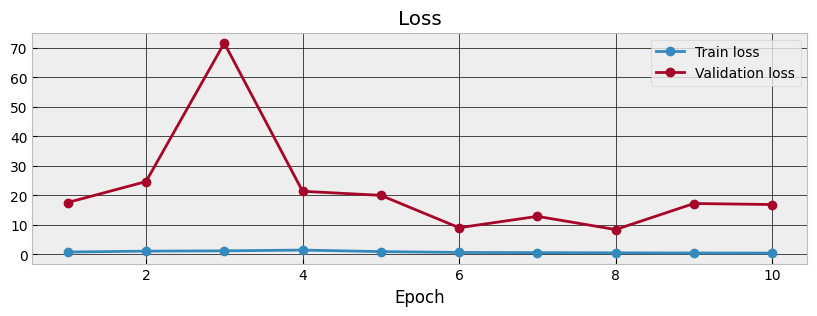

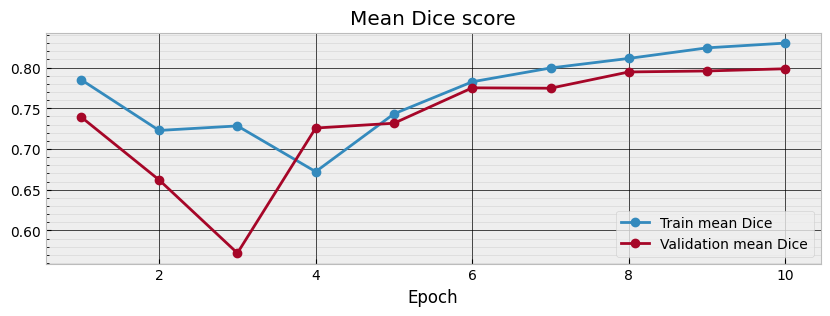

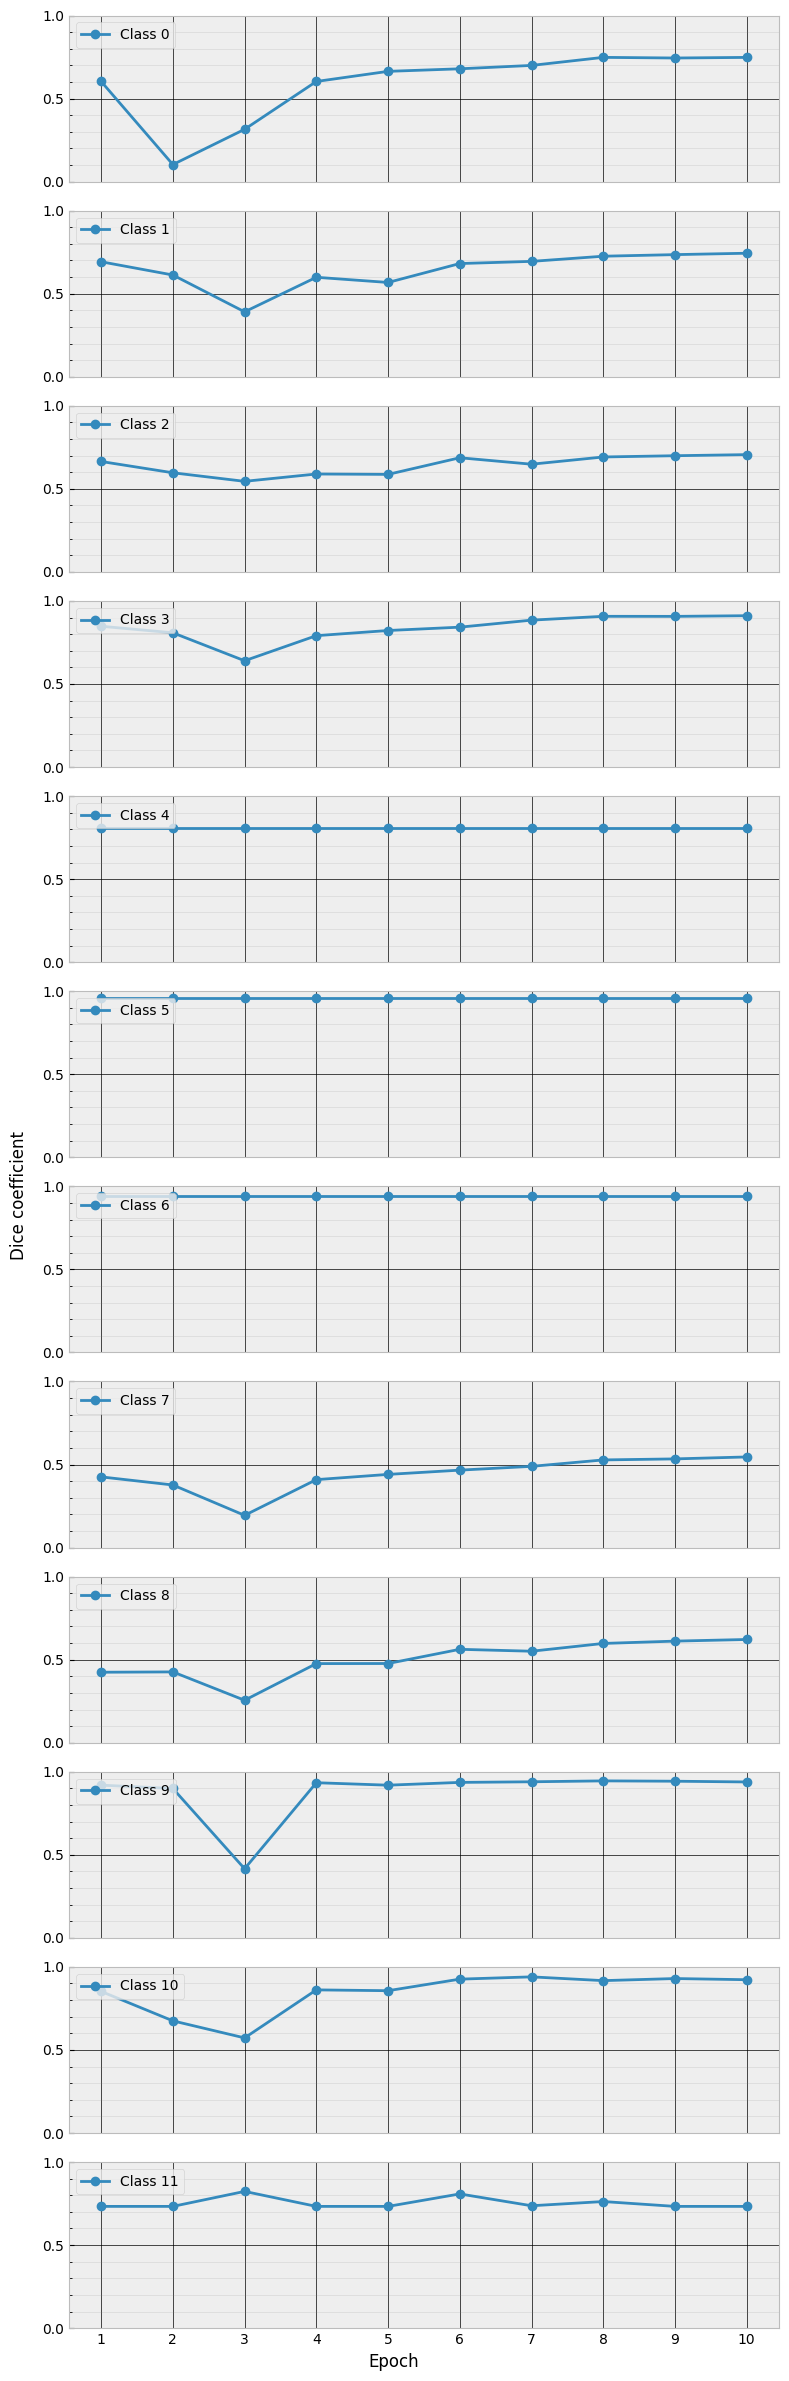

In [42]:
optimizer = smart_optimizer(model, "SGD", lr=config.LR, momentum=config.MOMENTUM, decay=config.WEIGHT_DECAY)
steps_per_epoch = int(len(train_dataloader) / config.GRADIENT_ACCUMULATION_STEPS)
total_steps = int(steps_per_epoch * config.EPOCHS)

# I've been using OneCycleLR for most of the training, but I suspect that I should keep training for more epochs at a constant LR
# and that OneCycleLR should be used when a larger number of epochs are used (I can only run 10 epochs at a time in Kaggle)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=config.MAX_LR, total_steps=total_steps)

# optimizer = smart_optimizer(model, "SGD", lr=config.MAX_LR, momentum=config.MOMENTUM, decay=config.WEIGHT_DECAY)
# scheduler = lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=total_steps / 10, eta_min=config.MIN_LR
# )

# Constant Learning Rate that I've identified as good when running OneCycleLR
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, total_iters=total_steps)

with ClearCache():
    H = train(model, optimizer, loss_fun, scorer, scheduler, config.EPOCHS, train_dataloader, valid_dataloader)
    plot_loss_and_score(config.EPOCHS, H)
    plot_score_per_class(H)

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

Format:
```
ImageID,EncodedPixels
01_0,1 1 5 1
01_1,2 3 8 1
02_0,1 1
02_1,3 1
03_0,1 1
03_1,4 5
etc.
```

In [43]:
output_lines = ["ImageID,EncodedPixels"]

for image_id in tqdm(test_ids):
    image_path = os.path.join(DATA_PATH, "imgs/imgs", f"{image_id}.jpg")

    # Load image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = test_transforms(image=image)
    transformed = transformed['image'].to(device, dtype=torch.float32)
    transformed = transformed.unsqueeze(0)
    
    with torch.no_grad():
        pred_mask = model(transformed)['out'].argmax(dim=1)
        pred_mask = pred_mask.detach().cpu().numpy()

    for class_id in range(config.NUM_CLASSES):
        class_mask = (pred_mask == class_id)
        class_image = np.zeros_like(pred_mask)
        class_image[class_mask] = pred_mask[class_mask]
        class_image[class_image > 0] = 1

        pred_rle = rle_to_string(rle_encode(class_image))

        output_line = f"{image_id}_{class_id},{pred_rle}"
        output_lines.append(output_line)

with open('submission.csv', "w") as f:
    out = "\n".join(line.strip() for line in output_lines)
    f.write(out)

  0%|          | 0/648 [00:00<?, ?it/s]

In [44]:
pd.read_csv("/kaggle/working/submission.csv")

ImageID  \
0      9743172603816335085_0   
1      9743172603816335085_1   
2      9743172603816335085_2   
3      9743172603816335085_3   
4      9743172603816335085_4   
...                      ...   
7771   4614757289603386106_7   
7772   4614757289603386106_8   
7773   4614757289603386106_9   
7774  4614757289603386106_10   
7775  4614757289603386106_11   

                                          EncodedPixels  
0                                                   NaN  
1     445347 11 446064 17 446781 21 447500 22 448218...  
2     447522 3 448241 5 448959 7 449679 8 450398 10 ...  
3                                                   NaN  
4                                                   NaN  
...                                                 ...  
7771  289467 1 290187 1 294491 8 295209 12 295928 14...  
7772  6 25 178 543 726 25 898 543 1446 25 1618 543 2...  
7773  300262 3 300980 6 301699 8 302418 8 303139 6 3...  
7774  14986 3 15704 5 16421 9 17140 10 17859 11 1857...  
7775                                                NaN  

[7776 rows x 2 columns]

## <font style="color:green">4.2. Inference [3 Points]</font>

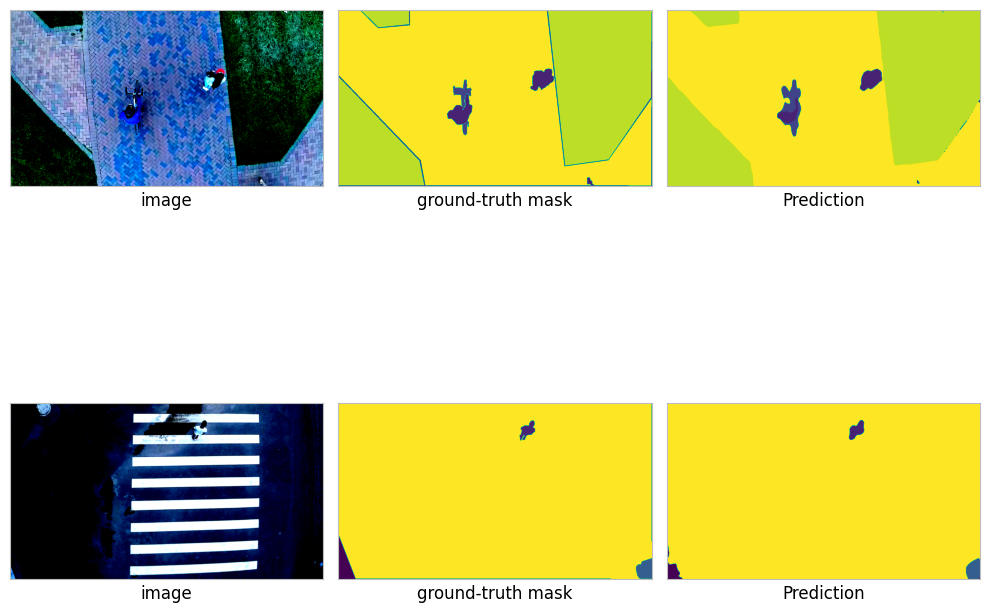

In [45]:
model.eval()

n_samples = 2

images, masks = next(iter(valid_dataloader))
images = images[:n_samples,...].to(device, dtype=torch.float32)

with torch.no_grad():
    preds = model(images.float())["out"].argmax(dim=1)

fig, ax = plt.subplots(nrows=n_samples, ncols=3, sharey=True, figsize=(10, 10))
for i in range(n_samples):

    image = images[i, ...]

    # CHW -> HWC
    image = image.permute(1, 2, 0).detach().cpu().numpy()

    mask = masks[i, ...]
    mask = torch.squeeze(mask)
    mask = mask.detach().cpu().numpy()

    pred = preds[i, ...].detach().cpu().numpy()

    ax[i][0].imshow(image)
    ax[i][0].set_xlabel("image")
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])

    ax[i][1].imshow(mask)
    ax[i][1].set_xlabel("ground-truth mask")
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])

    ax[i][2].imshow(pred)
    ax[i][2].set_xlabel("Prediction")
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])

plt.tight_layout()
plt.gcf().canvas.draw()
plt.show()
plt.close(fig)

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score.

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section.

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**